In [16]:
# to run in google colab
import sys
if 'google.colab' in sys.modules:
    import subprocess
    subprocess.call("pip install -U opencv-python".split())
    subprocess.call("wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/left.jpg".split())
    subprocess.call("wget https://raw.githubusercontent.com/YoniChechik/AI_is_Math/master/c_08_features/right.jpg".split())



In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
figsize = (10, 10)

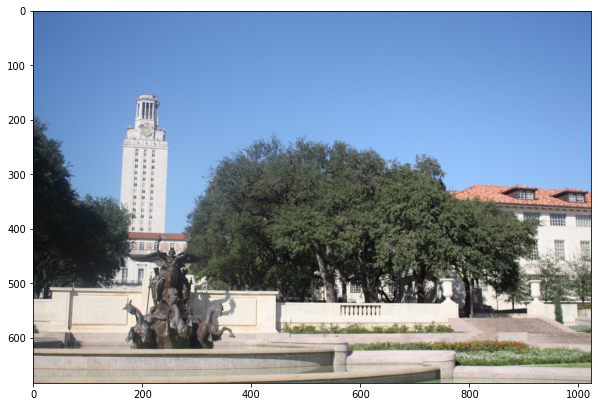

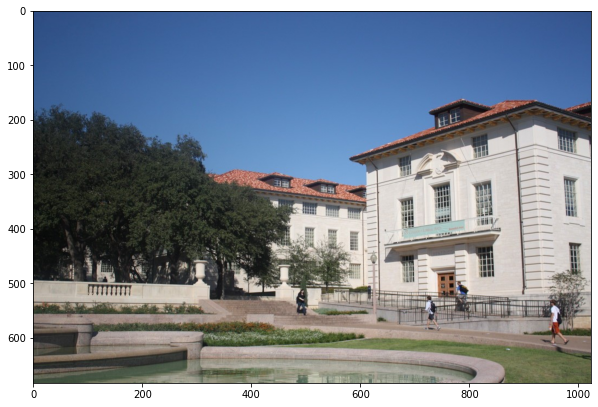

In [18]:
# Convert images into RGB for observation and GRAY for SIFT feature
rgb_l = cv2.cvtColor(cv2.imread("left.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("right.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

# Show images
plt.figure(figsize = figsize)
plt.imshow(rgb_l)
plt.show()

plt.figure(figsize = figsize)
plt.imshow(rgb_r)
plt.show()

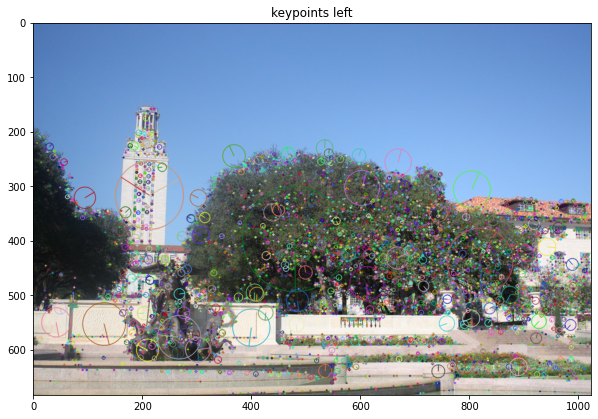

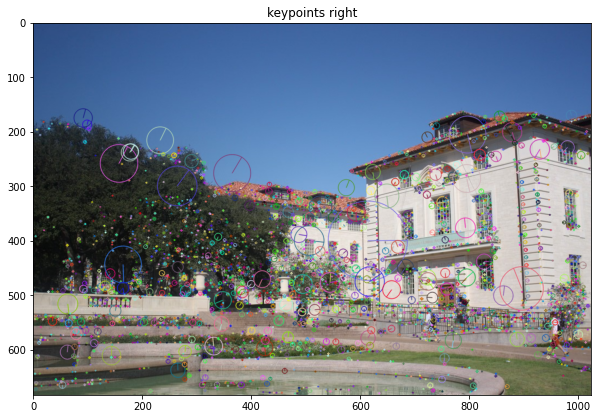

In [19]:
# Initiate SIFT Detector 
feature_extractor = cv2.SIFT_create()

# Find Keypoint and Descriptor with SIFT
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

# Show images woth Keypoint
test1 = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test1)
plt.title("keypoints left")
plt.show()

test2 = cv2.drawKeypoints(rgb_r, kp_r, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test2)
plt.title("keypoints right")
plt.show()

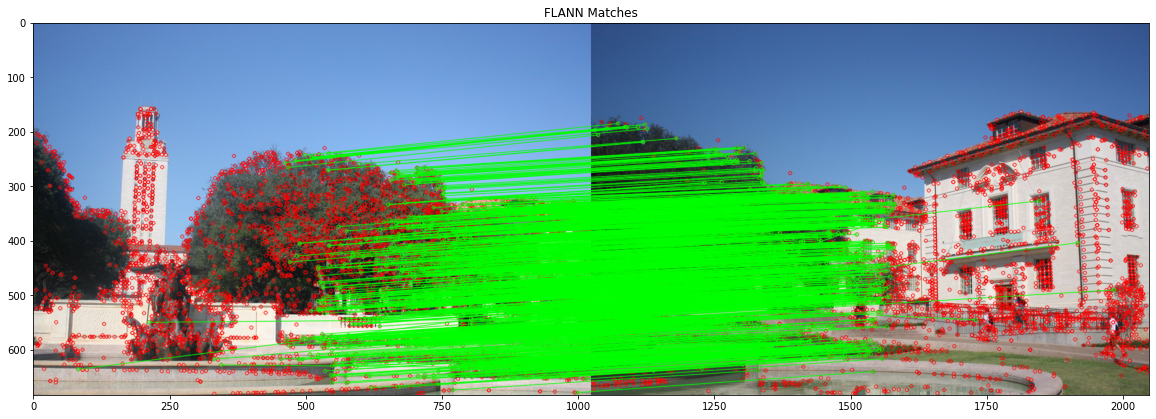

In [44]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

#Find matches with FLANN
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(desc_l,desc_r,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i] = [1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(rgb_l,kp_l,rgb_r,kp_r,matches,None,**draw_params)
plt.figure(figsize = (20,20))
plt.imshow(img3)
plt.title("FLANN Matches")
plt.show()

In [48]:
# Take good matches in tuple form
good_matches = []
for m in matches:
    if m[0].distance/m[1].distance < 0.7:
        good_matches.append(m)

# Calculate Homography Matrix
good_match_arr = np.asarray(good_matches)
good_kp_l = np.array([kp_l[m.queryIdx].pt for m in good_match_arr[:, 0]]).reshape(-1, 1, 2)
good_kp_r = np.array([kp_r[m.trainIdx].pt for m in good_match_arr[:, 0]]).reshape(-1, 1, 2)
H, masked = cv2.findHomography(good_kp_r, good_kp_l, cv2.RANSAC, 5.0)

print(H)

[[ 7.66042803e-01  3.66966191e-02  4.46660938e+02]
 [-1.35248960e-01  9.11525398e-01  7.61586467e+01]
 [-2.10640926e-04 -3.28427448e-05  1.00000000e+00]]


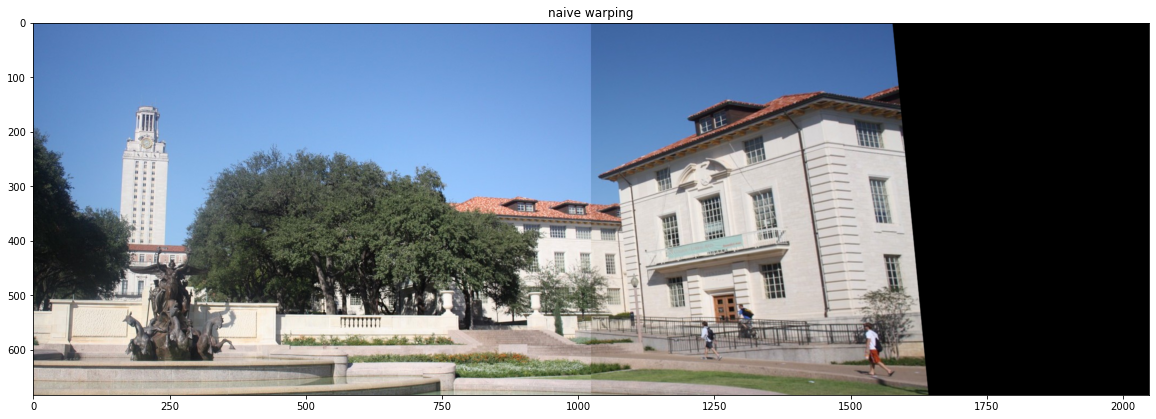

In [49]:
# Warping images
rgb_r_warped = cv2.warpPerspective(rgb_r, H, (rgb_l.shape[1] + rgb_r.shape[1], rgb_l.shape[0]))
rgb_r_warped[0:rgb_l.shape[0], 0:rgb_l.shape[1]] = rgb_l

plt.figure(figsize=(20,20))
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()

In [ ]:
cv2.imwrite("warped.jpg",rgb_r_warped)

True